### Project - Building IOT application for Smart City to enhance urban mobility by harnessing the power of IoT to make cities smarter and more livable. The system will utilize ML to classify traffic conditions and LSTMs for forecasting pickup trends.

#### Dataset- Source of the dataset is NYC Taxi & Limousine Commission (TLC) - https://github.com/fivethirtyeight/uber-tlc-foil-response. It was obtained by FiveThirtyEight through a Freedom of Information Law request on July 20, 2015.

In [ ]:
#pip install -U tensorflow

In [1]:
import pandas as pd
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from collections import Counter

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from tensorflow import keras
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation
from keras.utils import pad_sequences
#from keras.wrappers.scikit_learn import KerasClassifier
#from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline


## Load the Uber Data for the month of Jan-June 2015

In [2]:
from google.colab import drive
drive.mount('/content/drive')
path_uber_15='/content/drive/My Drive/ColabNotebooks/IOT/Final Project/uber-raw-data-janjune-15.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The dataset cosist for following columns -
1. Dispatching_base_num- The TLC base company code of the base that dispatched the Uber
2. Pickup_date- The date and time of the Uber pickup
3. Affiliated_base_num- The TLC base company code affiliated with the Uber pickup
4. locationID- The pickup location ID affiliated with the Uber pickup

In [3]:
df_uber = pd.read_csv(path_uber_15, delimiter = ",")
df_uber.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,B02617,2015-05-17 09:47:00,B02617,141
1,B02617,2015-05-17 09:47:00,B02617,65
2,B02617,2015-05-17 09:47:00,B02617,100
3,B02617,2015-05-17 09:47:00,B02774,80
4,B02617,2015-05-17 09:47:00,B02617,90


## Data Pre-processing

In [4]:
df_uber['Pickup_date']= pd.to_datetime(df_uber['Pickup_date'])

In [5]:
df_uber.dtypes

Dispatching_base_num            object
Pickup_date             datetime64[ns]
Affiliated_base_num             object
locationID                       int64
dtype: object

In [6]:
#convert datetime to epoch/unix time
from datetime import datetime
df_uber['unix']=df_uber['Pickup_date'].astype(int) / 10**9

In [7]:
df_uber.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,unix
0,B02617,2015-05-17 09:47:00,B02617,141,1.431856e+09
1,B02617,2015-05-17 09:47:00,B02617,65,1.431856e+09
2,B02617,2015-05-17 09:47:00,B02617,100,1.431856e+09
3,B02617,2015-05-17 09:47:00,B02774,80,1.431856e+09
4,B02617,2015-05-17 09:47:00,B02617,90,1.431856e+09


In [8]:
#Shape of uber data
df_uber.shape

(14270479, 5)

#### Check missing values

In [9]:
#Check number of rows with missing values
missing_value=df_uber.isna().sum()
missing_val = missing_value[missing_value > 0]
for missing_count in missing_val.items():
  print(f"Count of missing values {missing_count}")

Count of missing values ('Affiliated_base_num', 162195)


<Axes: >

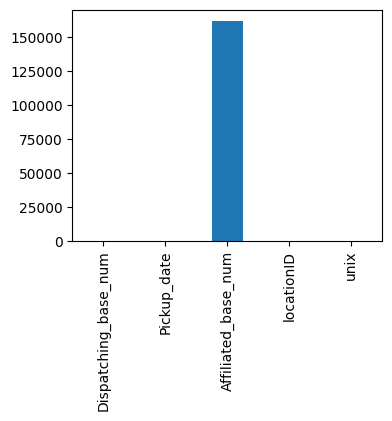

In [10]:
#Plot missing values
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(4,3))
missing_value.plot.bar()

In [11]:
#Remove rows with missing values
df_uber = df_uber.dropna()

In [16]:
missing_value=df_uber.isna().sum()
missing_val = missing_value[missing_value > 0]
for missing_count in missing_val.items():
  print(f"Count of missing values {missing_count}")
else:
  print("Data do not have any missing values")

Data do not have any missing values


<Axes: >

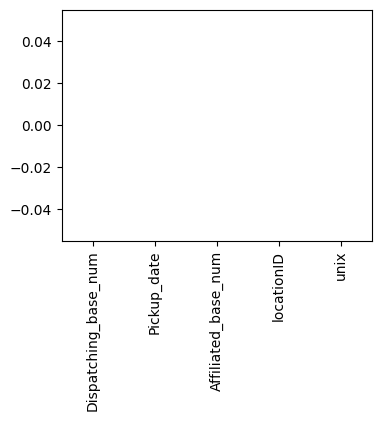

In [17]:
#plot after removing missing values
f, ax = plt.subplots(figsize=(4,3))
missing_value.plot.bar()

In [18]:
#Shape of data after removing missing values
df_uber.shape

(14108284, 5)

In [20]:
#Check duplicate rows in the dataset
duplicate_count=df_uber.duplicated().sum()
print(f"Count of duplicate data {duplicate_count}")

Count of duplicate data 896732


In [21]:
# Remove duplicate rows and check the sum of duplicate rows after removing duplicate rows
df_uber.drop_duplicates(inplace=True)
duplicate_count=df_uber.duplicated().sum()
print(f"Count of duplicate data after removing duplicate rows {duplicate_count}")

Count of duplicate data after removing duplicate rows 0


In [22]:
#Shape of data after removing duplicates
df_uber.shape

(13211552, 5)

## Summary Data Pre-processing
1. Uber data for Jan-June month contain **162195** missing values in Affiliated_base_num column.
2. Data contain **896732** duplicate rows
3. After pre-processing i.e. removing missing values and duplicate data, final dataset consist of **13,211,552** rows

## Perform Exploratory Data Analysis


In [23]:
#Derive month name, name of weekday, hour of the day, month and day numbers from Pickup_date in uber dataset
df_uber["month"] = df_uber["Pickup_date"].dt.month_name()
df_uber["weekday"] = df_uber["Pickup_date"].dt.day_name()
df_uber['hour'] = df_uber['Pickup_date'].dt.hour
df_uber['month_day'] = df_uber['Pickup_date'].apply(lambda pickup: pickup.strftime('%m-%d').split('-'))
df_uber['Monthumn'] = [month_day [0] for month_day in df_uber['month_day']]
df_uber['Day'] = [month_day [1] for month_day in df_uber['month_day']]

In [24]:
df_uber.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,unix,month,weekday,hour,month_day,Monthumn,Day
0,B02617,2015-05-17 09:47:00,B02617,141,1.431856e+09,May,Sunday,9,"[05, 17]",05,17
1,B02617,2015-05-17 09:47:00,B02617,65,1.431856e+09,May,Sunday,9,"[05, 17]",05,17
2,B02617,2015-05-17 09:47:00,B02617,100,1.431856e+09,May,Sunday,9,"[05, 17]",05,17
3,B02617,2015-05-17 09:47:00,B02774,80,1.431856e+09,May,Sunday,9,"[05, 17]",05,17
4,B02617,2015-05-17 09:47:00,B02617,90,1.431856e+09,May,Sunday,9,"[05, 17]",05,17


In [25]:
#Uber pickup count by month
df_uber["month"].value_counts()

June        2571771
May         2483980
February    2141306
April       2112705
March       2062639
January     1839151
Name: month, dtype: int64

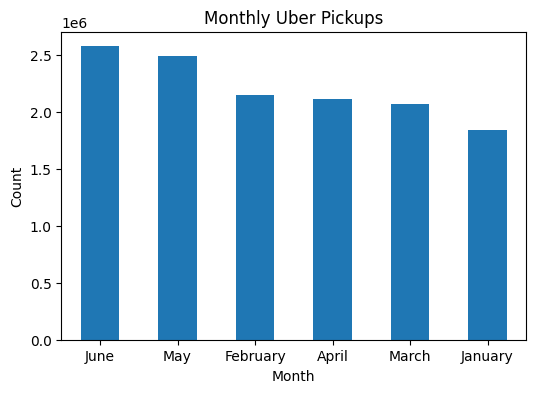

In [27]:
#Plot monthly pickup count
import matplotlib.pyplot as plt

# Plot data
counts = df_uber["month"].value_counts()
plt.figure(figsize=(6, 4))
counts.plot(kind="bar")
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Monthly Uber Pickups")
plt.xticks(rotation=0)
plt.show()

## Highest pickups were performed in the month of **June**

In [33]:
#Count of monthly pickups per weekday
monthweek = pd.crosstab(index=df_uber["month"], columns=df_uber["weekday"])
monthweek

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
month,,,,,,,
April,315002,238429,324545,273560,372522,250632,338015
February,360136,264693,354962,284432,323955,276956,276172
January,325261,182785,369693,219884,316857,188802,235869
June,371225,375312,399377,334434,357782,405500,328141
March,309631,269931,314785,313865,277026,320634,256767
May,430134,255501,464298,390391,337607,290004,316045


<Figure size 600x400 with 0 Axes>

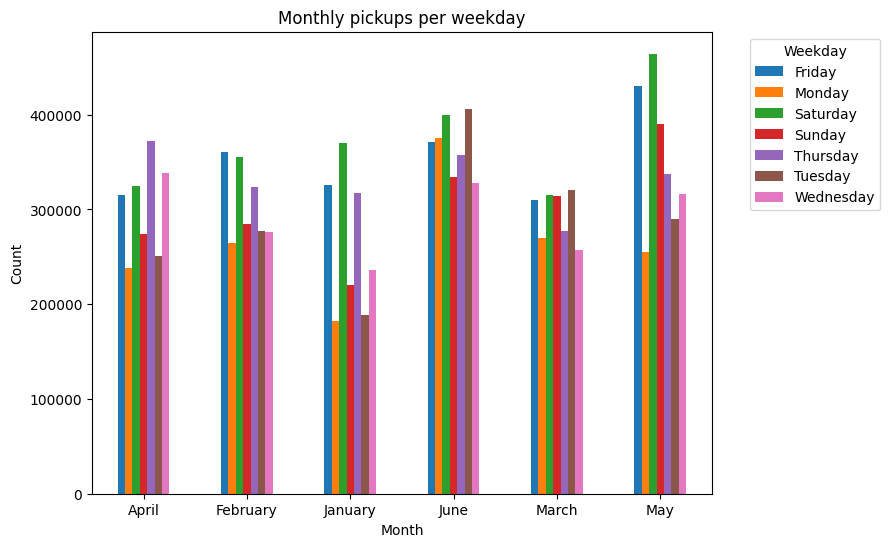

In [34]:
#plot monthly pickups per weekday
plt.figure(figsize=(6, 4))
#monthweek.plot(kind="bar", figsize=(8, 6), cmap='coolwarm')
monthweek.plot(kind="bar", figsize=(8, 6))
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Monthly pickups per weekday")
plt.xticks(rotation=0)

# Show the plot
plt.legend(title="Weekday", bbox_to_anchor=(1.05, 1), loc='upper left')  # Add legend
plt.show()

## Summary of Weekday pickup analysis per month
1. Highest number of pickups are performed Saturday in May compared to all other months
2. January, February - Highest pickups are on Saturday
3. March - Hightest pickups are on Tuesday
4. April - Hightest pickups are on Thursday
5. May - Highest pickups are on Saturday
6. June - Hightest pickups are on Tuesday

In [35]:
#Hourly analysis
summary = df_uber.groupby(['weekday', 'hour'], as_index=False).size()
summary.head()

,weekday,hour,size
0,Friday,0,78936
1,Friday,1,44064
2,Friday,2,26942
3,Friday,3,18845
4,Friday,4,22798


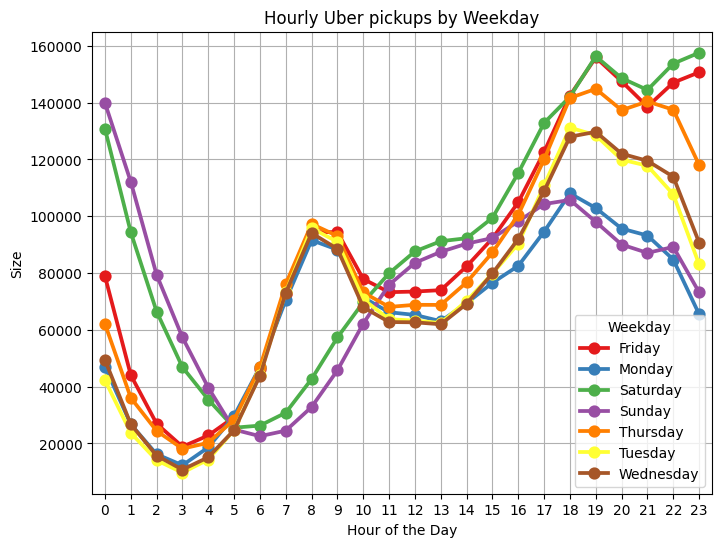

In [39]:
#plot Uber hourly analysis by weekday
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.pointplot(x="hour", y="size", hue="weekday", data=summary, palette="Set1")
plt.xlabel("Hour of the Day")
plt.ylabel("Size")
plt.title("Hourly Uber pickups by Weekday")
plt.legend(title="Weekday")
plt.grid(True)
plt.show()

## Summary of Hourly analysis by weekday
1. Friday and Saturday shows hightest numbers of pickups at 19 and 23 hour
2. Friday and Saturday shows upward trend in pickups after 21 hour vs Other days shows downward trend after 21 hour
3. Both Saturday and Sunday shows same trend between 0-14 hours however from 15 hours trend changes where Saturday has more number of pickups and pickup rise until 23 hours vs Sunday shows downward trend from 18 hour

In [40]:
#Unique location ids in uber data
unique_locid=df_uber['locationID'].unique()
len(unique_locid)

262

In [41]:
#Mark the location ids by traffic contition base on number of pickups performed per location ids
for loc in unique_locid:
  df_temp=df_uber.loc[df_uber['locationID']==loc]
  if (len(df_temp) < 100000):
    df_uber.loc[df_uber['locationID'] == loc, 'Traffic_conditions']='light'
  elif (len(df_temp)>=100000 and len(df_temp) <=250000 ):
    df_uber.loc[df_uber['locationID'] == loc, 'Traffic_conditions']='moderate'
  elif (len(df_temp)>=250000):
    df_uber.loc[df_uber['locationID'] == loc, 'Traffic_conditions']='heavy'

print(len(df_uber.loc[df_uber['Traffic_conditions']=='light']))
print(len(df_uber.loc[df_uber['Traffic_conditions']=='moderate']))
print(len(df_uber.loc[df_uber['Traffic_conditions']=='heavy']))
df_uber.head()

3284638
6028415
3898499


,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,unix,month,weekday,hour,month_day,Monthumn,Day,Traffic_conditions
0,B02617,2015-05-17 09:47:00,B02617,141,1.431856e+09,May,Sunday,9,"[05, 17]",05,17,moderate
1,B02617,2015-05-17 09:47:00,B02617,65,1.431856e+09,May,Sunday,9,"[05, 17]",05,17,light
2,B02617,2015-05-17 09:47:00,B02617,100,1.431856e+09,May,Sunday,9,"[05, 17]",05,17,moderate
3,B02617,2015-05-17 09:47:00,B02774,80,1.431856e+09,May,Sunday,9,"[05, 17]",05,17,moderate
4,B02617,2015-05-17 09:47:00,B02617,90,1.431856e+09,May,Sunday,9,"[05, 17]",05,17,moderate


In [42]:
df_uber.loc[(df_uber['Traffic_conditions']!='light') & (df_uber['Traffic_conditions']!='moderate') & (df_uber['Traffic_conditions']!='heavy' )]

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,unix,month,weekday,hour,month_day,Monthumn,Day,Traffic_conditions


In [43]:
df_uber.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,unix,month,weekday,hour,month_day,Monthumn,Day,Traffic_conditions
0,B02617,2015-05-17 09:47:00,B02617,141,1.431856e+09,May,Sunday,9,"[05, 17]",05,17,moderate
1,B02617,2015-05-17 09:47:00,B02617,65,1.431856e+09,May,Sunday,9,"[05, 17]",05,17,light
2,B02617,2015-05-17 09:47:00,B02617,100,1.431856e+09,May,Sunday,9,"[05, 17]",05,17,moderate
3,B02617,2015-05-17 09:47:00,B02774,80,1.431856e+09,May,Sunday,9,"[05, 17]",05,17,moderate
4,B02617,2015-05-17 09:47:00,B02617,90,1.431856e+09,May,Sunday,9,"[05, 17]",05,17,moderate


In [44]:
df_uber.to_csv('/content/drive/My Drive/ColabNotebooks/IOT/Final Project/uber-raw-data-janjune-15_trafficcond.csv', index = None)

## **Model 1 - Classify the traffic conditions (e.g., light, moderate, heavy) in different zones of NYC using Machine Learning Model**

In [46]:
#Sample dataset to be used for ML model training
random_sample = df_uber.sample(frac=0.01, random_state=42)
random_sample.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,unix,month,weekday,hour,month_day,Monthumn,Day,Traffic_conditions
8799280,B02764,2015-02-04 17:48:48,B02764,219,1.423072e+09,February,Wednesday,17,"[02, 04]",02,04,light
7479949,B02764,2015-04-19 05:34:00,B02764,262,1.429422e+09,April,Sunday,5,"[04, 19]",04,19,moderate
8955397,B02764,2015-06-25 13:05:00,B02670,140,1.435238e+09,June,Thursday,13,"[06, 25]",06,25,moderate
8303321,B02682,2015-05-02 18:17:00,B02682,112,1.430591e+09,May,Saturday,18,"[05, 02]",05,02,moderate
13462605,B02765,2015-06-17 18:51:00,B02765,90,1.434567e+09,June,Wednesday,18,"[06, 17]",06,17,moderate


In [47]:
light_cond=len(random_sample.loc[random_sample['Traffic_conditions']=='light'])
moderate_cond=len(random_sample.loc[random_sample['Traffic_conditions']=='moderate'])
heavy_cond=len(random_sample.loc[random_sample['Traffic_conditions']=='heavy'])
print(f"Sample data contain {light_cond} location ids with light traffic condition")
print(f"Sample data contain {moderate_cond} location ids with moderate traffic condition")
print(f"Sample data contain {heavy_cond} location ids with heavy traffic condition")

Sample data contain 32901 location ids with light traffic condition
Sample data contain 60403 location ids with moderate traffic condition
Sample data contain 38812 location ids with heavy traffic condition


In [48]:
# Preprocessing and spliting data
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC   # The SVM Classifier from Scikit
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
#% matplotlib inline
X = random_sample[['unix','locationID']]
#X = random_sample['locationID']
scaler = MinMaxScaler()
X_new = scaler.fit_transform(X)
y = random_sample['Traffic_conditions']
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)
X_train, X_test, Y_train, Y_test = train_test_split(X_new, y, test_size = 0.2, random_state = 323)


In [49]:
#Apply DecisionTreeClassifier ML model
#classifier = SVC(kernel = 'rbf', random_state = 45)
classifier = DecisionTreeClassifier(max_depth=10)
classifier.fit(X_train, Y_train)
#Predicting the Test Set
Y_pred = classifier.predict(X_test)

In [50]:
print("Accuracy is {}".format(accuracy_score(Y_test, Y_pred)))

Accuracy is 0.9955343627005753


<Axes: >

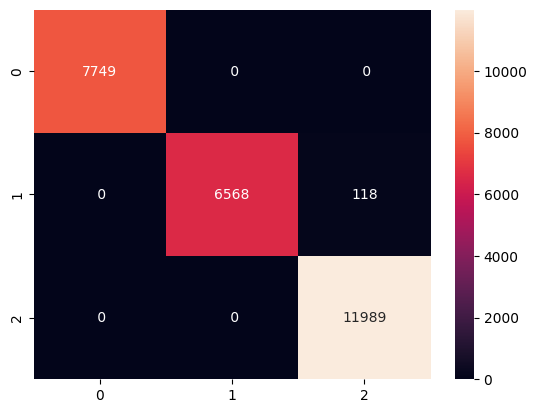

In [51]:
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm,annot=True,fmt='2.0f')

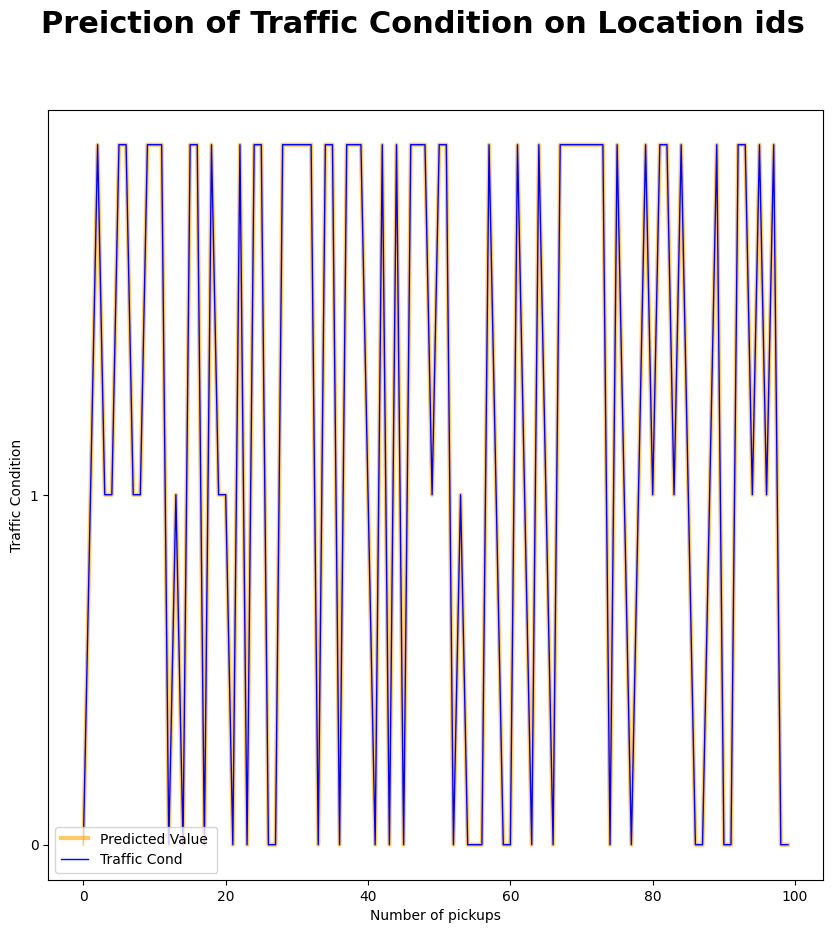

In [57]:
# Show predicted vs actual values for Traffic Condition for first 100 results
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Preiction of Traffic Condition on Location ids', fontsize=22, fontweight='bold')
#ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot( Y_pred[0:100], label='Predicted Value ', linewidth=3, color='orange', alpha=0.6)
ax.plot(Y_test[0:100], label='Traffic Cond',linewidth=1, color='blue')
ax.set( yticks=np.arange(Y_pred.min(), Y_pred.max(), 1), yticklabels=range(0, 2));
ax.set_xlabel('Number of pickups')
ax.set_ylabel('Traffic Condition')
ax.legend()

In [58]:
#Save ML model predictions
df_ml_predict=pd.DataFrame()
df_ml_predict['Traffic_Condition_Actual']=Y_test
df_ml_predict['Traffic_Condition_Predicted']=Y_pred
df_ml_predict.to_csv('/content/drive/My Drive/ColabNotebooks/IOT/Final Project/Final_Project_ML_Prediction.csv', index = None)

In [ ]:
# # define the  model
# model = Sequential()
# model.add(Dense(10, input_dim=X_train.shape[1], activation='relu', kernel_initializer='he_normal'))
# model.add(Dense(1, activation='sigmoid'))
# # compile the keras model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# # fit the keras model on the dataset
# model.fit(X_train, Y_train, epochs=10, batch_size=16, verbose=2)
# # evaluate the keras model
# _, accuracy = model.evaluate(X_test, Y_test, verbose=0)
# print('Accuracy: %.2f' % (accuracy*100))

## **Model 2 - Time Series Prediction – Forecast the future demand for Uber pickups across NYC using LSTM**

In [59]:
month_day_group = df_uber.groupby(by = ['Monthumn', 'Day']).size().unstack()
month_day_group

Day,01,02,03,04,05,06,07,08,09,10,...,22,23,24,25,26,27,28,29,30,31
Monthumn,,,,,,,,,,,,,,,,,,,,,
01,54369.0,37789.0,56440.0,39362.0,41045.0,50428.0,59771.0,68634.0,67709.0,75676.0,...,63139.0,69251.0,77850.0,55737.0,41921.0,24422.0,58188.0,66429.0,80565.0,88907.0
02,73855.0,66435.0,67531.0,64330.0,77814.0,82677.0,78290.0,60590.0,59971.0,62595.0,...,63870.0,68709.0,76462.0,72202.0,80585.0,85703.0,85069.0,NaN,NaN,NaN
03,65013.0,53372.0,67373.0,65268.0,69742.0,74966.0,74097.0,56893.0,50523.0,64741.0,...,63765.0,56395.0,59494.0,67387.0,71295.0,77449.0,83857.0,69077.0,58436.0,71292.0
04,64412.0,68539.0,71292.0,65223.0,55686.0,51019.0,62838.0,66425.0,71239.0,75417.0,...,74769.0,83122.0,90534.0,96260.0,81836.0,61267.0,64323.0,70306.0,77116.0,NaN
05,85097.0,95693.0,74748.0,61799.0,70715.0,74536.0,79739.0,83794.0,90412.0,74822.0,...,80253.0,73776.0,64869.0,56636.0,68003.0,80519.0,86293.0,89904.0,95821.0,89357.0
06,85030.0,87861.0,79747.0,85836.0,93082.0,93713.0,82361.0,71611.0,76059.0,80039.0,...,70212.0,84311.0,83254.0,90266.0,91319.0,119208.0,85442.0,69605.0,76246.0,NaN


In [60]:
## Aggregate results to form a time-series
month_day_series = [month_day_group.iloc[r,:] for r in range(month_day_group.shape[0])]

In [65]:
month_day_list=[]
for month in month_day_series:
  for days in month:
    month_day_list.append(days)

print(f"Length of Mondayday time-series {len(month_day_list)}")

Length of Mondayday time-series 186


In [66]:
## Remove missing values: here missing values are the days when a month is shorter than 31 days.
nan_indx=np.argwhere(np.isnan(month_day_list) == True)
print(f"number of missing values {len(nan_indx)}")
remove_inds = list(nan_indx.reshape((1,len(nan_indx)))[0])
print(f"ids tha are removed {remove_inds}")
month_day_list_nonan = [month_day_list[i] for i,j in enumerate(month_day_list) if i not in remove_inds]
print(f"Final Length of Monthday list {len(month_day_list_nonan)}")

number of missing values 5
ids tha are removed [59, 60, 61, 123, 185]
Final Length of Monthday list 181


In [67]:
## Convert time-series into data-frame for modeling process
df_uber_final = pd.DataFrame({'Days': range(1,len(month_day_list_nonan)+1), 'UberPickups': month_day_list_nonan})
df_uber_final.head()

,Days,UberPickups
0,1,54369.0
1,2,37789.0
2,3,56440.0
3,4,39362.0
4,5,41045.0


In [68]:
#Apply MinMax scalling to transforms data by scaling features to a given range (0,1)

from sklearn.preprocessing import MinMaxScaler

## Split into train-test set:
train_jan_june = df_uber_final.iloc[0:167,1:2].values
test_jan_june = df_uber_final.iloc[167:,1:2].values

print ('Training data: ', train_jan_june.shape)
print ('Testing data: ', test_jan_june.shape)

## Feature-scaling:
mms = MinMaxScaler(feature_range = (0,1))
train_jan_june_scaled = mms.fit_transform(train_jan_june)

Training data:  (167, 1)
Testing data:  (14, 1)


In [69]:
x_train = []
y_train = []

for rides in range(14, train_jan_june.shape[0]):
    x_train.append(train_jan_june_scaled[rides-14:rides,0])
    y_train.append(train_jan_june_scaled[rides,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, newshape = (x_train.shape[0], x_train.shape[1], 1))

In [70]:
## Import required modules:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import GridSearchCV
import time

In [71]:
np.random.seed(11)
t_start = time.time()

def build_rnn(num_units, input_x, input_y, drpout, epochs, size_of_batch, optimizer, loss):

    regressor = Sequential()

    ## Adding first LSTM layer:
    regressor.add(LSTM(units = num_units, return_sequences = True, input_shape = (input_x.shape[1],1)))
    regressor.add(Dropout(drpout))

    ## Adding second LSTM layer:
    regressor.add(LSTM(units = num_units, return_sequences = True))
    regressor.add(Dropout(drpout))

    ## Adding third LSTM layer:
    regressor.add(LSTM(units = num_units, return_sequences = True))
    regressor.add(Dropout(drpout))

    ## Adding fourth LSTM layer:
    regressor.add(LSTM(units = num_units, return_sequences = True))
    regressor.add(Dropout(drpout))

    ## Adding fifth LSTM layer:
    regressor.add(LSTM(units = num_units, return_sequences = False))
    regressor.add(Dropout(drpout))

    ## Adding o/p layer:
    regressor.add(Dense(units = 1))

    ## Compiling RNN:
    regressor.compile(optimizer = optimizer, loss = loss)

    ## Fitting RNN to training set:
    regressor.fit(x = input_x, y = input_y, epochs = epochs, batch_size = size_of_batch)

    return regressor

regressor = build_rnn(num_units = 40, input_x = x_train, input_y = y_train, drpout = 0.2, epochs = 1000, size_of_batch = 16, optimizer = 'adam', loss = 'mean_squared_error')

print (time.time() - t_start)

Epoch 1/1000
10/10 [==============================] - 11s 38ms/step - loss: 0.2216
Epoch 2/1000
10/10 [==============================] - 0s 34ms/step - loss: 0.0430
Epoch 3/1000
10/10 [==============================] - 0s 33ms/step - loss: 0.0322
Epoch 4/1000
10/10 [==============================] - 0s 46ms/step - loss: 0.0301
Epoch 5/1000
10/10 [==============================] - 1s 78ms/step - loss: 0.0285
Epoch 6/1000
10/10 [==============================] - 1s 63ms/step - loss: 0.0257
Epoch 7/1000
10/10 [==============================] - 0s 34ms/step - loss: 0.0235
Epoch 8/1000
10/10 [==============================] - 0s 32ms/step - loss: 0.0225
Epoch 9/1000
10/10 [==============================] - 0s 33ms/step - loss: 0.0228
Epoch 10/1000
10/10 [==============================] - 0s 33ms/step - loss: 0.0264
Epoch 11/1000
10/10 [==============================] - 0s 32ms/step - loss: 0.0283
Epoch 12/1000
10/10 [==============================] - 0s 33ms/step - loss: 0.0222
Epoch 13/100

In [72]:
# using last 14 values to predict the next value
adjusted_inputs = df_uber_final[len(df_uber_final) - len(test_jan_june) - 14:]['UberPickups'].values
adjusted_inputs = adjusted_inputs.reshape(-1,1)
adjusted_inputs = mms.transform(adjusted_inputs)
adjusted_inputs[0:10]

array([[0.65726947],
       [0.72960772],
       [0.81569131],
       [0.82318768],
       [0.68832419],
       [0.56061254],
       [0.61345546],
       [0.66073847],
       [0.79777604],
       [0.82472022]])

In [73]:
## Create properly structured test set:
x_test = []
for rides in range(14,29):
    x_test.append(adjusted_inputs[rides-14:rides,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, newshape = (x_test.shape[0], x_test.shape[1], 1))
x_test.shape


(15, 14, 1)

In [74]:
## Make prediction for test set and bring values back to original scale
pred = regressor.predict(x_test)
pred = mms.inverse_transform(pred)

## Check RMSE on test-set
residuals = pred[0:-1] - test_jan_june
rmse = np.sqrt(np.mean(residuals**2))
rmse

1/1 [==============================] - 2s 2s/step


10512.275268536967

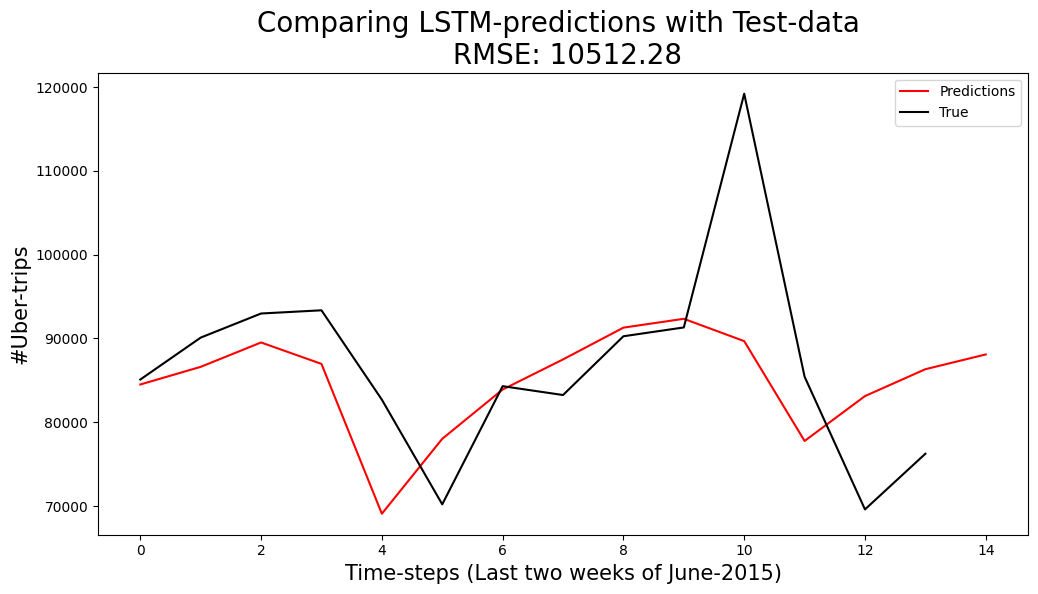

In [75]:
fig, ax = plt.subplots(figsize = (12,6))

e = [i*0.05 for i in pred]
ax.plot(pred, color = 'red', label = 'Predictions')
#ax.errorbar(x = range(15), y = pred, yerr = e, fmt = '*', color = 'r')
ax.plot(test_jan_june, color = 'black', label = 'True')

ax.set_xlabel('Time-steps (Last two weeks of June-2015)', fontsize = 15)
ax.set_ylabel('#Uber-trips', fontsize = 15)
ax.set_title('Comparing LSTM-predictions with Test-data \n RMSE: {}'.format(np.round(rmse,2)), fontsize = 20)

ax.legend()
plt.show()

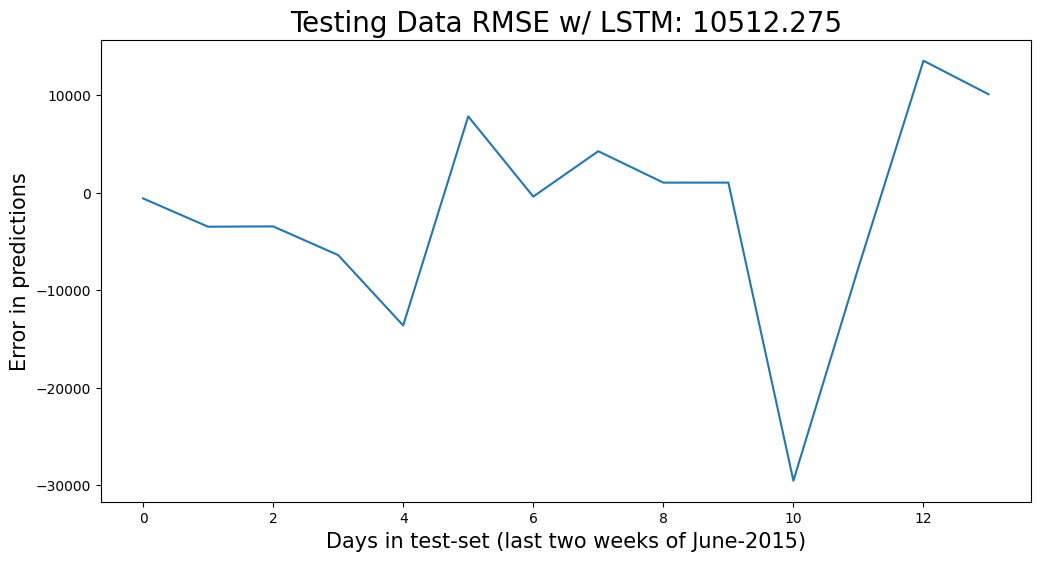

In [76]:
fig ,ax = plt.subplots(figsize = (12,6))
ax.plot(residuals)

ax.set_xlabel('Days in test-set (last two weeks of June-2015)', fontsize = 15)
ax.set_ylabel('Error in predictions', fontsize = 15)
ax.set_title('Testing Data RMSE w/ LSTM: {}'.format(round(rmse, 3)), fontsize = 20)
plt.show()

5/5 [==============================] - 0s 10ms/step


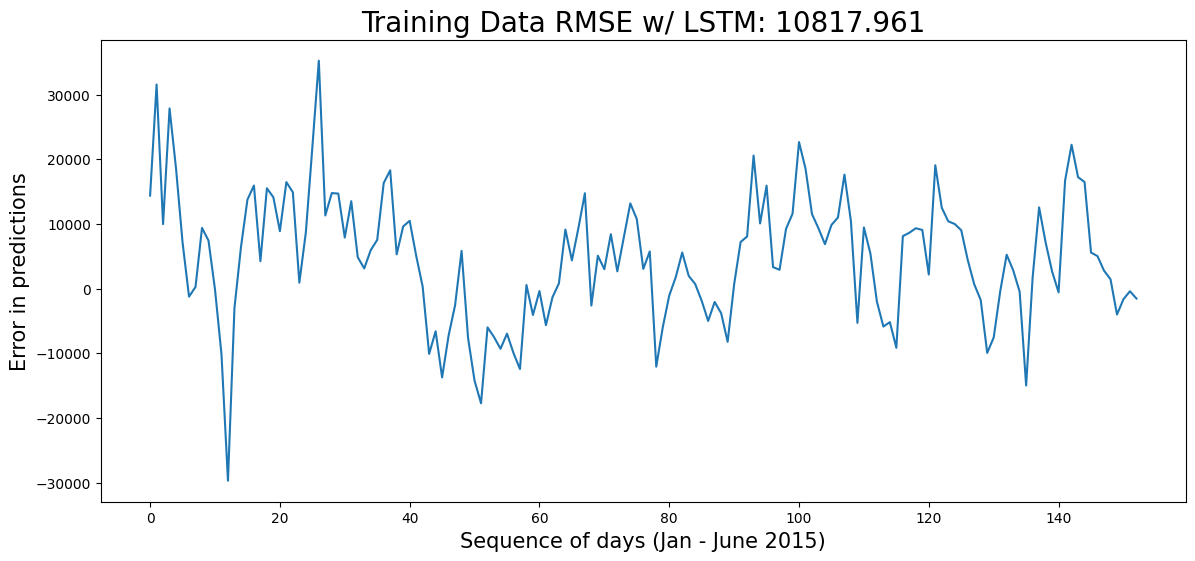

In [77]:
pred_train = regressor.predict(x_train)
pred_train = mms.inverse_transform(pred_train)

residuals_train = pred_train - train_jan_june[0:-14]
rmse_train = np.sqrt(np.mean(residuals_train**2))

fig, ax = plt.subplots(figsize = (14,6))
ax.plot(residuals_train)
ax.set_xlabel('Sequence of days (Jan - June 2015)', fontsize = 15)
ax.set_ylabel('Error in predictions', fontsize = 15)
ax.set_title('Training Data RMSE w/ LSTM: {}'.format(round(rmse_train,3)), fontsize = 20)
plt.show()

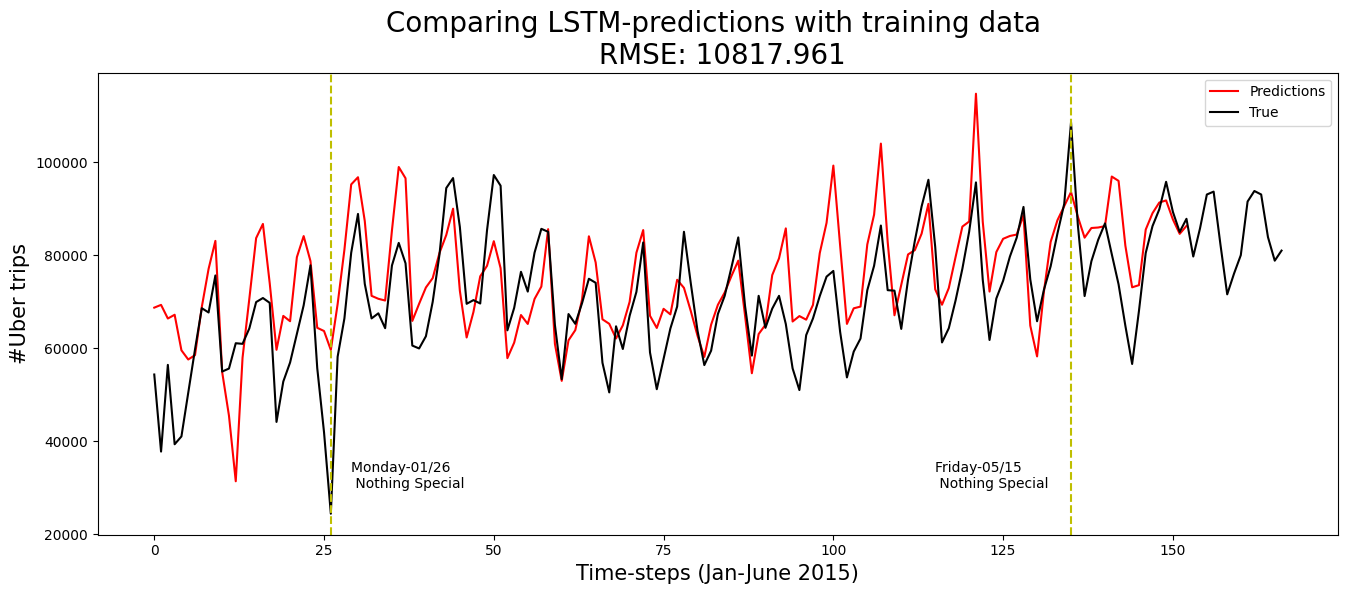

In [78]:
fig, ax = plt.subplots(figsize = (16,6))

ax.plot(pred_train, color = 'red', label = 'Predictions')
ax.plot(train_jan_june, color = 'black', label = 'True')

ax.axvline(x = 26, color = 'y', linestyle = 'dashed')
ax.text(x = 29, y = 30000, s = 'Monday-01/26 \n Nothing Special')

ax.axvline(x = 135, color = 'y', linestyle = 'dashed')
ax.text(x = 115, y = 30000, s = 'Friday-05/15 \n Nothing Special')

ax.set_xlabel('Time-steps (Jan-June 2015)', fontsize = 15)
ax.set_ylabel('#Uber trips', fontsize = 15)
ax.set_title('Comparing LSTM-predictions with training data \n RMSE: {}'.format(round(rmse_train,3)), fontsize = 20)

ax.legend()
plt.show()

In [79]:
#Export prediction results for LSTM
df_pred=pd.DataFrame()
df_pred['Actual_trips']=train_jan_june[0:-14].flatten()
df_pred['Predicted_trips']=pred_train

In [80]:
df_pred.to_csv('/content/drive/My Drive/ColabNotebooks/IOT/Final Project/Final_Project_LSTM_Prediction.csv', index = None)